**Professor J. Morlier**

Example from 	
Machine learning for (meta-)materials design Dr. Sid Kumar 
Delft University of Technology

In [1]:
pip install smt

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: tsfresh 0.18.0 has a non-standard dependency specifier matrixprofile>=1.1.10<2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tsfresh or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
# imports:  
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0);
import pandas as pd

![beam](/home/dmsm/gi.catalani/Projects/IA_course_VAE/IA_CNRS_ICA/E2/image_beam.png)

### Input: 
$F\ [\text{N}], L\ [\text{m}], E\ [\text{GPa}], I\ [\text{cm}^4]$

### Output: 
$\delta\ [\text{mm}], \theta\ [^\circ]$

In [2]:
# Load data from .csv file using pandas (Review the code yourself)
url = 'https://raw.githubusercontent.com/jomorlier/IA_CNRS_ICA/main/data-3AB-train.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,F,L,E,I,delta,theta
0,0,4332.0460,9.743647,149.62566,13769.5790,64.835020,0.571876
1,1,3768.7124,7.837019,176.82217,7472.7240,45.762386,0.501847
2,2,3728.9172,10.387497,108.84774,6640.5680,192.739000,1.594676
3,3,4275.6396,6.315188,113.20305,11324.9160,27.999197,0.381042
4,4,4434.5146,10.639669,130.74228,7858.1377,173.290020,1.399779


In [3]:
# Define train data (tip: convert df values to float: .astype(np.float32))
#df = pd.read_csv('data-3AB-train.csv')
x_train = torch.tensor(df[['F','L','E','I']].astype(np.float32).values)
x_train=x_train[0::2]

y_train = torch.tensor(df[['delta','theta']].astype(np.float32).values)
y_train=y_train[0::2]


In [4]:
url = 'https://raw.githubusercontent.com/jomorlier/IA_CNRS_ICA/main/data-3AB-test.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,F,L,E,I,delta,theta
0,0,4516.9890,8.244241,191.636600,8841.7050,49.792652,0.519073
1,1,4269.4453,9.690850,155.663670,8085.7340,102.903270,0.912601
2,2,2629.9240,10.303864,102.867850,11772.0200,79.193886,0.660550
3,3,3858.4973,9.092241,164.992510,8435.7580,69.457860,0.656545
4,4,3438.8110,10.044767,117.809326,5665.3403,174.060840,1.489275


In [5]:
# Define test data (tip: convert df values to float: .astype(np.float32))
#df = pd.read_csv('data-3AB-test.csv')
x_test = torch.tensor(df[['F','L','E','I']].astype(np.float32).values)
y_test = torch.tensor(df[['delta','theta']].astype(np.float32).values)

## Visualize your data!

In [6]:
# Check x-data shape
# Please comment the data
x_train.shape

torch.Size([1000, 4])

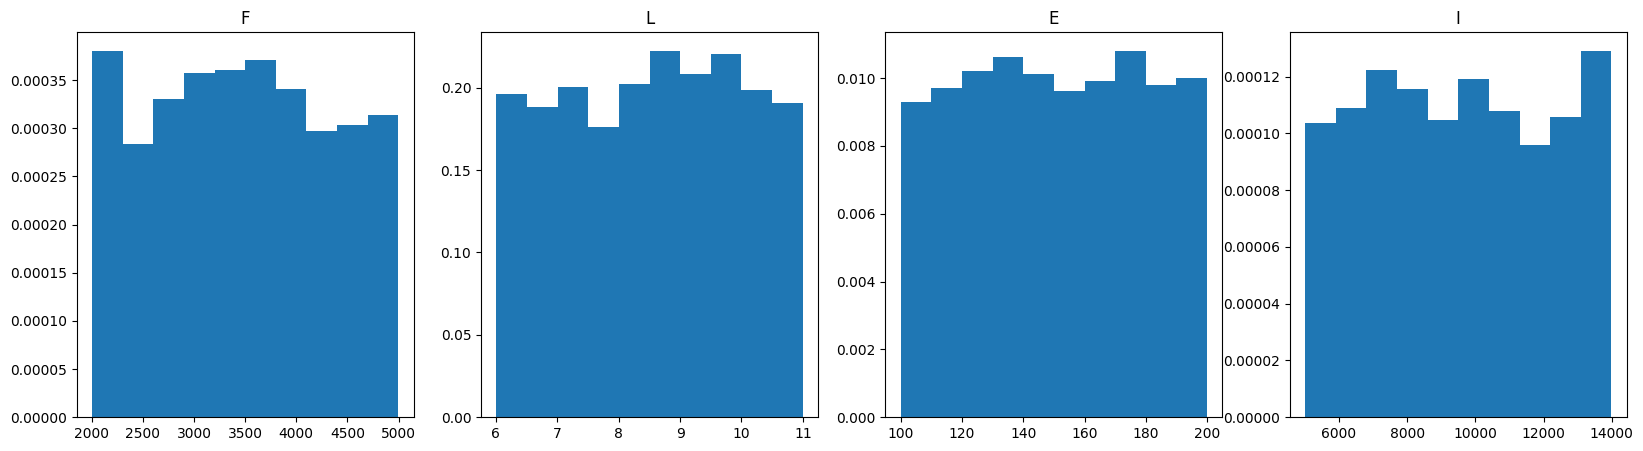

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].hist(x_train[:,0].detach().numpy(),density=True); axes[0].set_title('F');
axes[1].hist(x_train[:,1].detach().numpy(),density=True); axes[1].set_title('L');
axes[2].hist(x_train[:,2].detach().numpy(),density=True); axes[2].set_title('E');
axes[3].hist(x_train[:,3].detach().numpy(),density=True); axes[3].set_title('I');

What do you think about the values of different variables?

In [9]:
# Check y-data shape
y_train.shape

torch.Size([1000, 2])

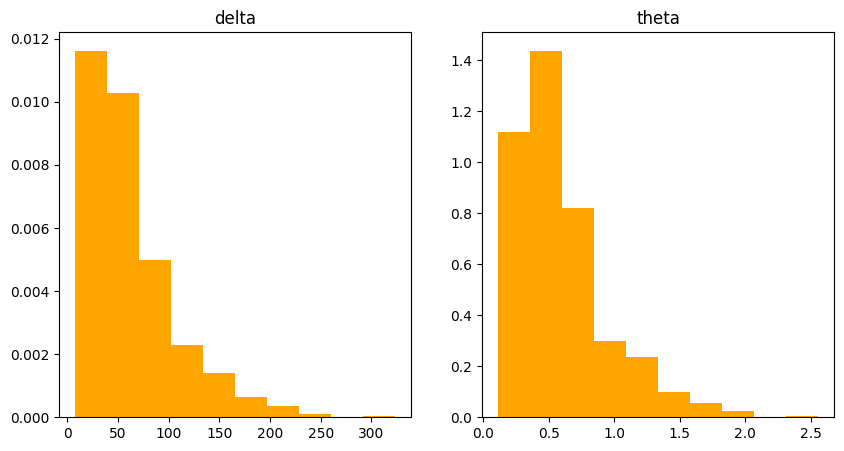

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(y_train[:,0].detach().numpy(),density=True,color='orange'); axes[0].set_title('delta');
axes[1].hist(y_train[:,1].detach().numpy(),density=True,color='orange'); axes[1].set_title('theta');

## Normalize your data


Normalization is an important step for scale consistency.

In [9]:
class Normalization:
    def __init__(self,data):
        
        # empty list of min and max values of each column
        self.min_values = []
        self.max_values = []
        
        # find min and max of each column and store in lists
        for i in range(data.shape[1]):
            self.min_values.append(torch.min(data[:,i]))
            self.max_values.append(torch.max(data[:,i]))
        
    def normalize(self, data):
        
        # clone the data before modification
        normalized_data = data.clone()
        
        #iterate over all columns
        for i in range(0, data.shape[1]):
            
            # z = a+b*z', where z' in [-1,1] is normalized data
            # min_z = a-b, when z'=-1
            # max_z = a+b, when z'=1
            # normalize each column between values 0 and 1 range
            a = (self.max_values[i]+self.min_values[i])/2.
            b = (self.max_values[i]-self.min_values[i])/2.
            normalized_data[:,i] = (data[:,i]-a)/b
        
        # return
        return normalized_data
    
    def unnormalize(self, data):
        
        # clone the data before modification
        unnormalized_data = data.clone()
        
        #iterate over all columns
        for i in range(0, data.shape[1]):            
            
            # z = a+b*z', where z' in [-1,1] is normalized data
            # min_z = a-b, when z'=-1
            # max_z = a+b, when z'=1
            # unnormalize each column to original range
            a = (self.max_values[i]+self.min_values[i])/2.
            b = (self.max_values[i]-self.min_values[i])/2.
            unnormalized_data[:,i] = a + b*data[:,i]          
            
        # return
        return unnormalized_data


In [10]:
# Always use TRAINING DATA ONLY for identifying min and max values for normalization
x_normalization = Normalization(x_train)
y_normalization = Normalization(y_train)

# Normalize both training and test data
x_train = x_normalization.normalize(x_train)
x_test = x_normalization.normalize(x_test)

y_train = y_normalization.normalize(y_train)
y_test = y_normalization.normalize(y_test)

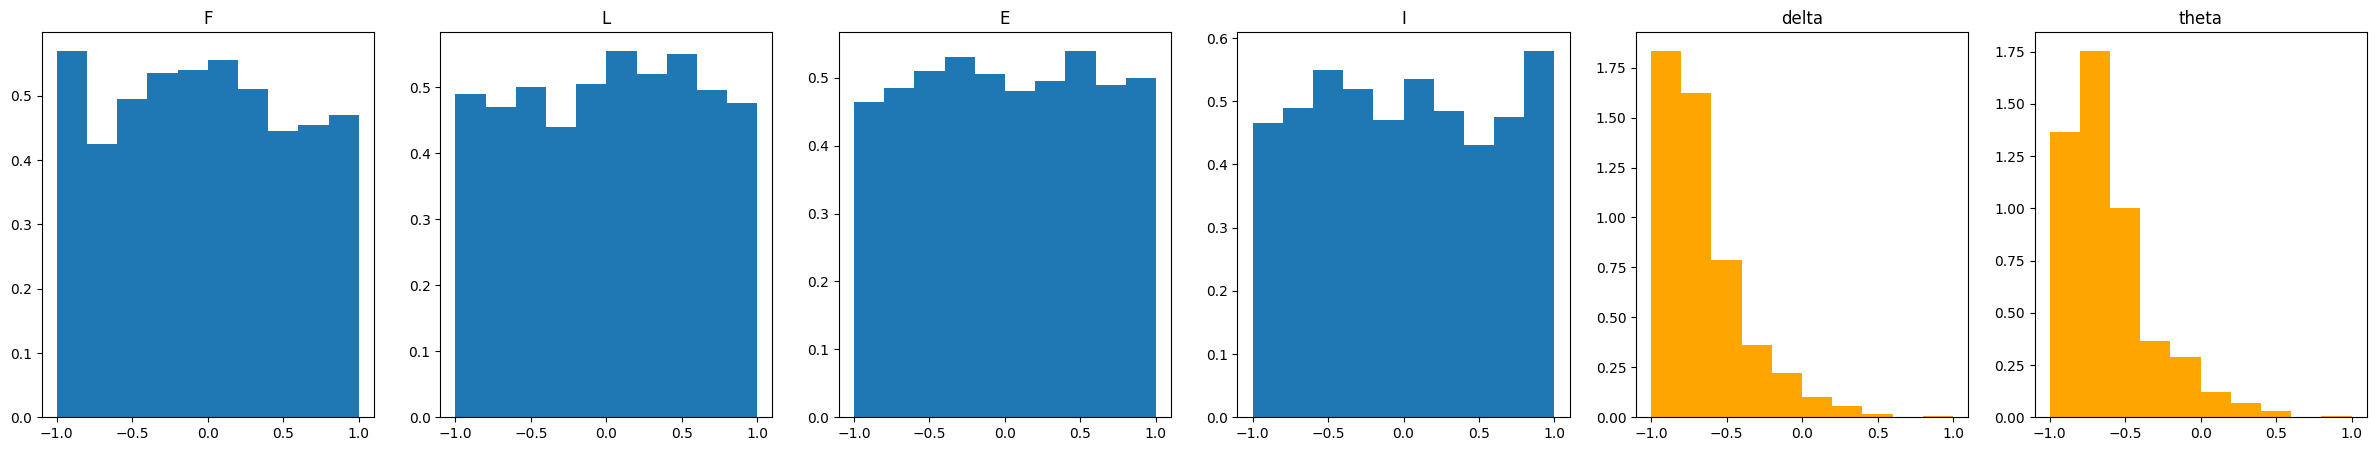

In [11]:
# Visualize the normalized data
fig, axes = plt.subplots(1, 6, figsize=(30, 5))
axes[0].hist(x_train[:,0].detach().numpy(),density=True); axes[0].set_title('F');
axes[1].hist(x_train[:,1].detach().numpy(),density=True); axes[1].set_title('L');
axes[2].hist(x_train[:,2].detach().numpy(),density=True); axes[2].set_title('E');
axes[3].hist(x_train[:,3].detach().numpy(),density=True); axes[3].set_title('I');
axes[4].hist(y_train[:,0].detach().numpy(),density=True,color='orange'); axes[4].set_title('delta');
axes[5].hist(y_train[:,1].detach().numpy(),density=True,color='orange'); axes[5].set_title('theta');

In [14]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = torch.nn.Linear(4,10)
        self.layer2 = torch.nn.Linear(10,10)
        self.layer3 = torch.nn.Linear(10,2)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = NN()
# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.01

# Optimizer: use Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = torch.nn.MSELoss()

# Number of epochs
num_epochs = 5000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = model(x_train)
    
    # Compute the loss. 
    train_loss = loss_function(y_train_pred, y_train)
    
    
    # store the loss in a list
    train_loss_history.append(train_loss.detach().item())
    
    
    # Call .backward() on loss to compute gradient (d_loss/d_a)
    train_loss.backward()
    
    # Update the model paramaeters
    # No need for torch.no_grad() anymore with in-built optimizers
    optimizer.step()
    
    # remove any pre-exisitng gradients stored
    optimizer.zero_grad()
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad(): #torch.no_grad() is back because we don't train on test data and so don't need gradients
        
        # Make your predictions
        y_test_pred = model(x_test)
        
        # Compute the loss.
        test_loss = loss_function(y_test_pred, y_test)
        
        
        # store the loss in a list
        test_loss_history.append(test_loss.detach().item())

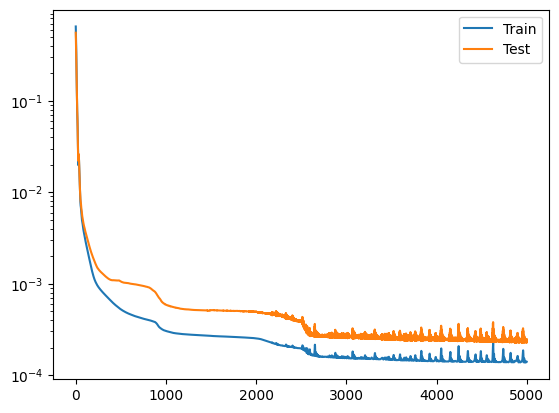

In [15]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test'])

In [16]:
def calculate_R2(true, pred):
    # Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)


def plotR2(true, pred):
    dim = true.shape[1]
    fig = plt.figure(figsize=plt.figaspect(1./dim))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([true[:,index].min(),true[:,index].max()],[true[:,index].min(),true[:,index].max()],c='red')
        ax.set_title('Label dim: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(dim):
        ax = fig.add_subplot(1, dim, i+1); helper(ax,i)
    fig.tight_layout()

In [17]:
with torch.no_grad():
    # Make prediction on test set
    y_test_pred = model(x_test)

In [18]:
# Unnormalize all y-data
# To-do
y_train = y_normalization.unnormalize(y_train)
y_test = y_normalization.unnormalize(y_test)
y_test_pred = y_normalization.unnormalize(y_test_pred)

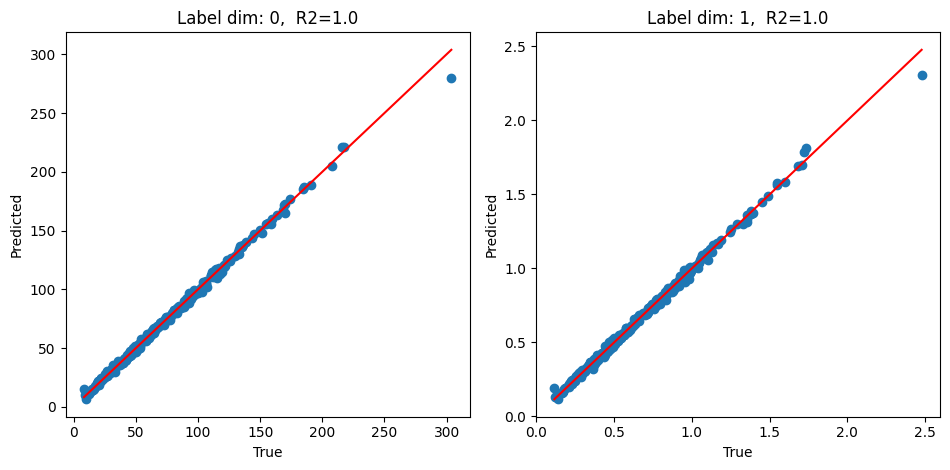

In [19]:
# Visualize accuracy
plotR2(y_test, y_test_pred)

**COMPARE WITH GPR**
and SMT ;)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
exception :  61-th leading minor of the array is not positive definite
[ 9.25042461e+01  1.48055534e+00  1.82305114e+00  1.97593440e+00
  1.96656498e+00  4.55318892e-02  4.26791780e-02  3.46829622e-02
  2.75223902e-02  2.38908456e-02  2.15264955e-02  1.55747175e-02
  1.44674792e-02  9.95805504e-03  9.11189939e-03  7.72909128e-04
  6.60253810e-04  4.38440894e-04  3.90963128e-04  3.24467008e-04
  2.90863755e-04  2.43465031e-04  2.39839747e-04  2.16607175e-04
  2.02280511e-04  1.89570886e-04  1.43233542e-04  1.19237554e-04
  9.44388318e-05  8.41144334e-05  7.52356480e-05  5.84790600e-05
  4.42900973e-05  3.79821664e-05  2.9

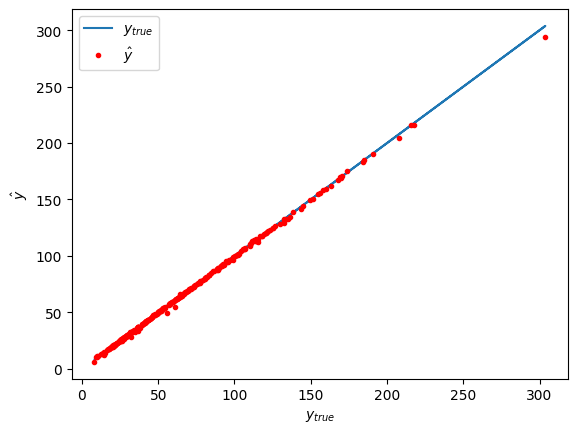

In [20]:
from smt.surrogate_models import KRG

# Load data from .csv file using pandas (Review the code yourself)
url = 'https://raw.githubusercontent.com/jomorlier/IA_CNRS_ICA/main/data-3AB-train.csv'
df = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe
#df = pd.read_csv('data-3AB-train.csv')
x_train = df[['F','L','E','I']].astype(np.float32).values
x_train=x_train[0::20]
#print(x_train)
y_train1 = df[['delta']].astype(np.float32).values
y_train1 = y_train1[0::20]
y_train2 = df[['theta']].astype(np.float32).values
y_train2 = y_train2[0::20]

url = 'https://raw.githubusercontent.com/jomorlier/IA_CNRS_ICA/main/data-3AB-test.csv'
df = pd.read_csv(url)
#df = pd.read_csv('data-3AB-test.csv')
x_test = df[['F','L','E','I']].astype(np.float32).values
y_test1 = df[['delta']].astype(np.float32).values
y_test2 = df[['theta']].astype(np.float32).values

sm = KRG(theta0=[1e-2], poly='constant', corr='squar_exp')
#sm = KRG(theta0=[1e-2], poly='constant', corr='matern52')
sm.set_training_values(x_train, y_train1)
sm.train()


# Prediction of the validation points
y1 = sm.predict_values(x_test)
#print('LS,  err: '+str(compute_rms_error(y,x_test,y_test)))

# Plot prediction/true values

fig = plt.figure()
plt.plot(y_test1, y_test1, '-', label='$y_{true}$')
plt.plot(y_test1, y1, 'r.', label='$\hat{y}$')
       
plt.xlabel('$y_{true}$')
plt.ylabel('$\hat{y}$')
        
plt.legend(loc='upper left')
#plt.title('LS model: validation of the prediction model')


from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %f"
      % mean_squared_error(y_test1, y1))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %f' % r2_score(y_test1, y1))


#surrogate2
sm = KRG(theta0=[1e-2], poly='constant', corr='squar_exp')
#sm = KRG(theta0=[1e-2], poly='constant', corr='matern52')
sm.set_training_values(x_train, y_train2)
sm.train()


# Prediction of the validation points
y2 = sm.predict_values(x_test)
#print('LS,  err: '+str(compute_rms_error(y,x_test,y_test)))

Mean squared error: 1.526150
Variance score (R2): 0.999527


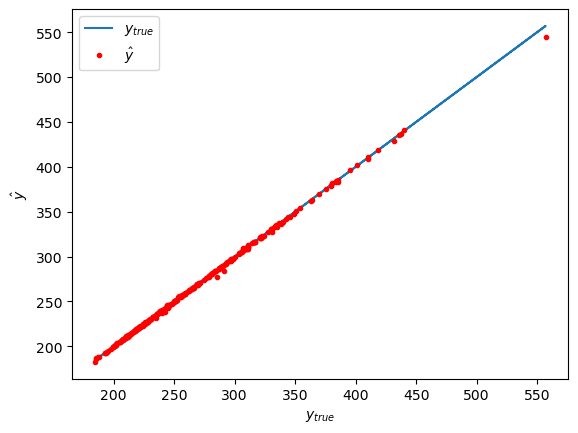

In [26]:
# Unnormalize all y-data
y_train1 = y_normalization.unnormalize(torch.from_numpy(y_train1))
y_train2 = y_normalization.unnormalize(torch.from_numpy(y_train2))
y_test1  = y_normalization.unnormalize(torch.from_numpy(y_test1))
y_test2  = y_normalization.unnormalize(torch.from_numpy(y_test2))
y1 = y_normalization.unnormalize(torch.from_numpy(y1))
y2 = y_normalization.unnormalize(torch.from_numpy(y2))

# Plot prediction/true values

fig = plt.figure()
plt.plot(y_test2, y_test2, '-', label='$y_{true}$')
plt.plot(y_test2, y2, 'r.', label='$\hat{y}$')
       
plt.xlabel('$y_{true}$')
plt.ylabel('$\hat{y}$')
        
plt.legend(loc='upper left')
#plt.title('LS model: validation of the prediction model')

# The mean squared error
print("Mean squared error: %f"
      % mean_squared_error(y_test2, y2))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %f' % r2_score(y_test2, y2))

-----

# Constrained surrogate optimization

Target: $\delta=150 \text{mm}$ ($=-0.0933$ after normalization)

Given: $F = 2500 N$ ($=-0.6681$ after normalization)

Find appropriate parameters: $L, E, I$ to achieve this value of target $\delta$:

### $$\min_{L,E,I} (\delta - \delta_\text{target})^2$$

But normalized $L$ (also $E$, $I$) are constrained to certain bounds ($L\in[-1,+1]$ after normalization).

Therefore, set $L=\text{tanh}(L_p)$, with $L_p\in[-\infty,+\infty]$.

Then, the problem becomes an unconstrianed optimization (which is easier to solve)

### $$\min_{L_p,E_p,I_p} (\delta - \delta_\text{target})^2$$



-----

![image.png](attachment:f7258cd2-6625-4801-ba82-855a208252ec.png)


L: 10.466443061828613
E: 110.56278228759766
I: 5763.3671875


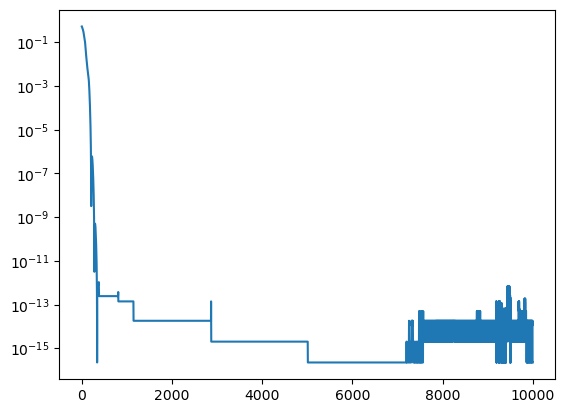

In [27]:
given_F = -0.6681
target_delta = -0.0933

# Define L, E, I as scalar tensors with requires_grad=True and some initial guess
L_p = torch.tensor([0.], requires_grad=True) 
E_p = torch.tensor([0.], requires_grad=True)
I_p = torch.tensor([0.], requires_grad=True) 

# Define an empty list to store loss history
loss_history = []

# lr
lr = 0.01

# num_epochs
num_epochs = 10000

# optimizer
optimizer = torch.optim.Adam([L_p,E_p,I_p], lr=lr)

# define the tanh function
tanh = torch.nn.Tanh()
    
# Lets write an optimization loop to improve the predictions and find the parameters
for i in range(num_epochs):
    
    # Prepare input matrix
    x = torch.zeros(1,4)
    x[0,0] = given_F
    x[0,1] = tanh(L_p)
    x[0,2] = tanh(E_p)
    x[0,3] = tanh(I_p)
    
    # predict y_pred
    y_pred = nn(x)
    
    # Extract delta
    delta = y_pred[0,0]
    
    # Compute loss as squared value of difference from target delta
    loss = (delta - target_delta)**2

    # store the loss in a list
    loss_history.append(loss.detach().item())

    # compute gradient of loss relative to x using backward()
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    # Remove any existing gradients for next iteration
    optimizer.zero_grad()

# Plot loss history
plt.plot(loss_history)
plt.yscale('log')


# Print L, E, I
x = torch.zeros(1,4)
x[0,0] = given_F
x[0,1] = tanh(L_p)
x[0,2] = tanh(E_p)
x[0,3] = tanh(I_p)
x = x_normalization.unnormalize(x)
print('L:',x[0,1].detach().item())
print('E:',x[0,2].detach().item())
print('I:',x[0,3].detach().item())

# Moral of the story: 

- ### Use any PRE-TRAINED neural network as just another torch-based function that is differentiable. 

- ### The computational graph is automatically propagated through the neural entwork by PyTorch. 

- ### The differentiability can be used for any kind of optimization or even, training another neural network (as you will see in the project). 

- ### Using GP with lots of close related data create problems to inverse the matrix of covariance. Undersampling is a simple solution in this case.

